In [1]:
from langchain.document_loaders import PyPDFLoader

file_path = "./assets-resources/attention-paper.pdf"

docs = PyPDFLoader(file_path).load_and_split()

docs[0]

Document(metadata={'source': './assets-resources/attention-paper.pdf', 'page': 0}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple networ

In [2]:
len(docs)

16

In [3]:
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

In [5]:
from langchain.chains.combine_documents import create_stuff_documents_chain

chain = create_stuff_documents_chain(llm, rag_prompt)
chain

RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableLambda(format_docs)
}), kwargs={}, config={'run_name': 'format_inputs'}, config_factories=[])
| ChatPromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.\n\n{context}"), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={})])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x118108290>, async_client=<openai.resources.chat.completions.AsyncCompletion

In [6]:
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(docs, embedding)

In [7]:
retriever = vectordb.as_retriever()

In [8]:
from langchain.chains import create_retrieval_chain

In [9]:
retrieval_chain = create_retrieval_chain(retriever, chain)

In [10]:
retrieval_chain.invoke({"input": "What is the main idea of the paper?"})

{'input': 'What is the main idea of the paper?',
 'context': [Document(metadata={'page': 14, 'source': './assets-resources/attention-paper.pdf'}, page_content='Input-Input Layer5\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nInput-Input Layer5\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nFigure 5: Many of the attention heads exhibit behaviour that seems related to the structure of the\nsentence. We give two such examples above, from two different heads from the encoder

In [11]:
output = retrieval_chain.invoke({"input": "What is the main architecture discussed in the paper? Just output its name"})

output['answer']

'The Transformer.'

In [12]:
from langchain_core.output_parsers import StrOutputParser

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),
    ('human', '{input}')
])

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain_from_docs = (
    {
        'input': lambda x: x['input'],
        'context': lambda x: format_docs(x['context']), 
    }
    | prompt
    | llm
    | StrOutputParser()
)

In [13]:
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x10f65e950>, search_kwargs={})

In [14]:
# passing the input query to the retriever
retrieve_docs = (lambda x: x['input']) | retriever

In [15]:
retrieve_docs

RunnableLambda(lambda x: x['input'])
| VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x10f65e950>, search_kwargs={})

In [16]:
from langchain_core.runnables import RunnablePassthrough

chain = RunnablePassthrough.assign(context=retrieve_docs).assign(
    answer=rag_chain_from_docs
)
chain

RunnableAssign(mapper={
  context: RunnableLambda(lambda x: x['input'])
           | VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x10f65e950>, search_kwargs={})
})
| RunnableAssign(mapper={
    answer: {
              input: RunnableLambda(...),
              context: RunnableLambda(...)
            }
            | ChatPromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.\n\n{context}"), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, par

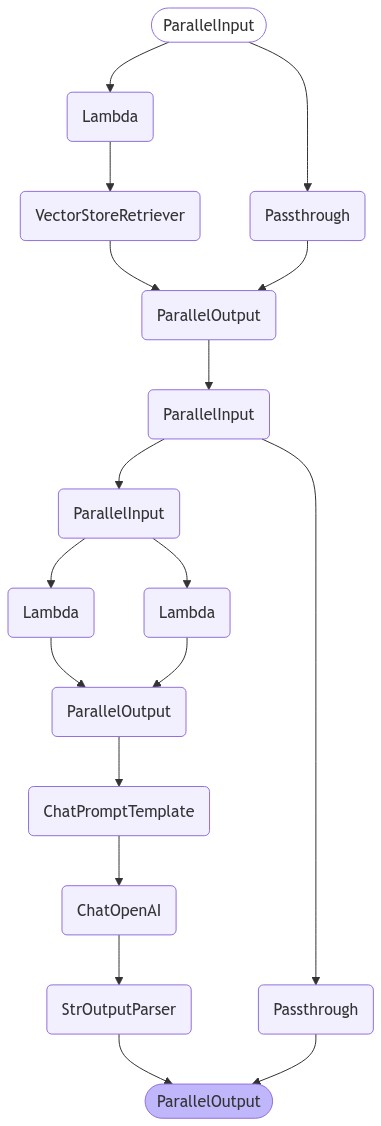

In [17]:
from IPython.display import Image

Image(chain.get_graph().draw_mermaid_png())

In [18]:
chain.invoke({"input": "Explain in simple terms the self-attention mechanism according to the paper."})  

{'input': 'Explain in simple terms the self-attention mechanism according to the paper.',
 'context': [Document(metadata={'page': 0, 'source': './assets-resources/attention-paper.pdf'}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming mode